https://coremltools.readme.io/docs/introductory-quickstart

In [1]:
!ls ../Models/yolo

QuantizedYolov4-tiny-416.mlmodel       yolov4-tiny-custom-S2_last.weights
yolov4-tiny-416.h5                     yolov4-tiny-custom-S_final_Ori.weights
yolov4-tiny-416.mlmodel


In [2]:
import tensorflow as tf
import coremltools as ct
keras_model = tf.keras.models.load_model("../Models/yolo/yolov4-tiny-416.h5", compile=False)
input_image = tf.keras.layers.Input(shape=(416, 416, 3), name="image")
pred_bbox = keras_model(input_image)

boxes = tf.reshape(pred_bbox[:, :, 0:4], (-1, 4))
scores = tf.reshape(pred_bbox[:, :, 4:], (-1, 1))

full_model = tf.keras.Model(inputs=[input_image], outputs=[boxes, scores])
full_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, None, None)   5880324     image[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, None, None)] 0           functional_1[0][0]               
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, None, None)] 0           functional_1[0][0]               
_______________________________________________________________________________________

In [3]:
# Convert the model using the Unified Conversion API
model = ct.convert(
    full_model, 
    inputs=[ct.ImageType(scale=1/255.0)],
)

output_sizes = [4, 1]
for i in range(2):
    ma_type = model._spec.description.output[i].type.multiArrayType
    ma_type.shapeRange.sizeRanges.add()
    ma_type.shapeRange.sizeRanges[0].lowerBound = 0
    ma_type.shapeRange.sizeRanges[0].upperBound = -1
    ma_type.shapeRange.sizeRanges.add()
    ma_type.shapeRange.sizeRanges[1].lowerBound = output_sizes[i]
    ma_type.shapeRange.sizeRanges[1].upperBound = output_sizes[i]
    del ma_type.shape[:]

Translating MIL ==> MLModel Ops: 100%|██████████| 620/620 [00:00<00:00, 1009.72 ops/s]


In [4]:
nms_spec = ct.proto.Model_pb2.Model()
nms_spec.specificationVersion = 5
for i in range(2):
    decoder_output = model._spec.description.output[i].SerializeToString()
    nms_spec.description.input.add()
    nms_spec.description.input[i].ParseFromString(decoder_output)
    nms_spec.description.output.add()
    nms_spec.description.output[i].ParseFromString(decoder_output)
    
nms_spec.description.output[0].name = "coordinates"
nms_spec.description.output[1].name = "confidence"

# output_sizes = [1, 4]
# for i in range(2):
#     ma_type = nms_spec.description.output[i].type.multiArrayType
#     ma_type.shapeRange.sizeRanges.add()
#     ma_type.shapeRange.sizeRanges[0].lowerBound = 0
#     ma_type.shapeRange.sizeRanges[0].upperBound = -1
#     ma_type.shapeRange.sizeRanges.add()
#     ma_type.shapeRange.sizeRanges[1].lowerBound = output_sizes[i]
#     ma_type.shapeRange.sizeRanges[1].upperBound = output_sizes[i]
#     del ma_type.shape[:]
    
#     ma_type2 = nms_spec.description.input[i].type.multiArrayType
#     ma_type2.shapeRange.sizeRanges.add()
#     ma_type2.shapeRange.sizeRanges[0].lowerBound = 0
#     ma_type2.shapeRange.sizeRanges[0].upperBound = -1
#     ma_type2.shapeRange.sizeRanges.add()
#     ma_type2.shapeRange.sizeRanges[1].lowerBound = output_sizes[i]
#     ma_type2.shapeRange.sizeRanges[1].upperBound = output_sizes[i]
#     del ma_type2.shape[:]
    
nms = nms_spec.nonMaximumSuppression
nms.confidenceInputFeatureName = "Identity_1"
nms.coordinatesInputFeatureName = "Identity"
nms.confidenceOutputFeatureName = "confidence"
nms.coordinatesOutputFeatureName = "coordinates"
nms.iouThresholdInputFeatureName = "iouThreshold"
nms.confidenceThresholdInputFeatureName = "confidenceThreshold"

default_iou_threshold = 0.6
default_confidence_threshold = 0.4
nms.iouThreshold = default_iou_threshold
nms.confidenceThreshold = default_confidence_threshold
nms.pickTop.perClass = True

nms_model = ct.models.MLModel(nms_spec)

In [5]:
model

input {
  name: "image"
  type {
    imageType {
      width: 416
      height: 416
      colorSpace: RGB
      imageSizeRange {
        widthRange {
          lowerBound: 416
          upperBound: 416
        }
        heightRange {
          lowerBound: 416
          upperBound: 416
        }
      }
    }
  }
}
output {
  name: "Identity"
  type {
    multiArrayType {
      dataType: FLOAT32
      shapeRange {
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 4
          upperBound: 4
        }
      }
    }
  }
}
output {
  name: "Identity_1"
  type {
    multiArrayType {
      dataType: FLOAT32
      shapeRange {
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 1
          upperBound: 1
        }
      }
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.3.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.versio

In [6]:
nms_model

input {
  name: "Identity"
  type {
    multiArrayType {
      dataType: FLOAT32
      shapeRange {
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 4
          upperBound: 4
        }
      }
    }
  }
}
input {
  name: "Identity_1"
  type {
    multiArrayType {
      dataType: FLOAT32
      shapeRange {
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 1
          upperBound: 1
        }
      }
    }
  }
}
output {
  name: "coordinates"
  type {
    multiArrayType {
      dataType: FLOAT32
      shapeRange {
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 4
          upperBound: 4
        }
      }
    }
  }
}
output {
  name: "confidence"
  type {
    multiArrayType {
      dataType: FLOAT32
      shapeRange {
        sizeRanges {
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 1
          upperBound: 1
 

In [7]:
from coremltools.models import datatypes
from coremltools.models.pipeline import *
input_features = [ ("image", datatypes.Array(416, 416, 3)),
                   ("iouThreshold", datatypes.Double()),
                   ("confidenceThreshold", datatypes.Double()) ]

output_features = [ "confidence", "coordinates" ]

pipeline = Pipeline(input_features, output_features)

pipeline.add_model(model)
pipeline.add_model(nms_model)

pipeline.spec.description.input[0].ParseFromString(
    model._spec.description.input[0].SerializeToString())
pipeline.spec.description.output[0].ParseFromString(
    nms_model._spec.description.output[0].SerializeToString())
pipeline.spec.description.output[1].ParseFromString(
    nms_model._spec.description.output[1].SerializeToString())

42

In [8]:
# Save model
# model.save("../Models/yolo/yolov4-tiny-416.mlmodel") 
final_model = ct.models.MLModel(pipeline.spec)
final_model.save("../Models/yolo/yolov4-tiny-416.mlmodel")
# Load a saved model
loaded_model = ct.models.MLModel("../Models/yolo/yolov4-tiny-416.mlmodel")

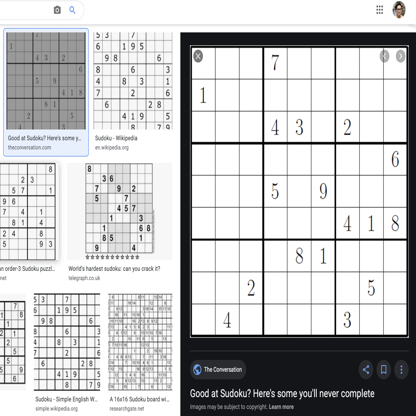

In [9]:
from PIL import Image
import numpy as np
example_image = Image.open("../Datasets/ss1.PNG").resize((416,416)).convert('RGB')
example_image

In [10]:
# Make a prediction using Core ML
out_dict = loaded_model.predict({"image": example_image, "iouThreshold": 0.5, "confidenceThreshold": 0.5})
out_dict

{'coordinates': array([[0.44165862, 0.13232793, 0.99988836, 0.8029062 ]], dtype=float32),
 'confidence': array([[0.88121426]], dtype=float32)}

# Quantization

https://apple.github.io/coremltools/generated/coremltools.models.neural_network.quantization_utils.html

In [11]:
from coremltools.models.neural_network import quantization_utils
quantized_model = quantization_utils.quantize_weights(loaded_model, 8, "linear")
quantized_model.save("../Models/yolo/QuantizedYolov4-tiny-416.mlmodel")

Quantizing using linear quantization
Optimizing Neural Network before Quantization:
Fused functional_1/functional_1/conv2d/Conv2Dx->batch_norm_0
Fused functional_1/functional_1/conv2d_1/Conv2Dx->batch_norm_1
Fused functional_1/functional_1/conv2d_2/Conv2Dx->batch_norm_2
Fused functional_1/functional_1/conv2d_3/Conv2Dx->batch_norm_3
Fused functional_1/functional_1/conv2d_4/Conv2Dx->batch_norm_4
Fused functional_1/functional_1/conv2d_5/Conv2Dx->batch_norm_5
Fused functional_1/functional_1/conv2d_6/Conv2Dx->batch_norm_6
Fused functional_1/functional_1/conv2d_7/Conv2Dx->batch_norm_7
Fused functional_1/functional_1/conv2d_8/Conv2Dx->batch_norm_8
Fused functional_1/functional_1/conv2d_9/Conv2Dx->batch_norm_9
Fused functional_1/functional_1/conv2d_10/Conv2Dx->batch_norm_10
Fused functional_1/functional_1/conv2d_11/Conv2Dx->batch_norm_11
Fused functional_1/functional_1/conv2d_12/Conv2Dx->batch_norm_12
Fused functional_1/functional_1/conv2d_13/Conv2Dx->batch_norm_13
Fused functional_1/functiona

In [19]:
# Make a prediction using Core ML
out_dict = quantized_model.predict({"image": example_image, "iouThreshold": 0.6, "confidenceThreshold": 0.4})
out_dict

{'coordinates': array([[0.44043896, 0.13299206, 1.0005016 , 0.8028051 ]], dtype=float32),
 'confidence': array([[0.88391155]], dtype=float32)}

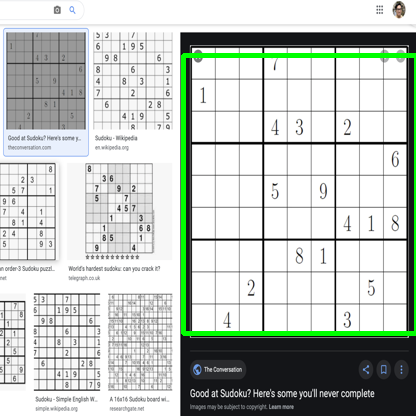

In [20]:
import cv2
img = np.array(example_image)

for i in range(out_dict['coordinates'].shape[0]):
    cv2.rectangle(img, 
                  (int(416*out_dict['coordinates'][i][0]), int(416*out_dict['coordinates'][i][1])), 
                  (int(416*out_dict['coordinates'][i][2]), int(416*out_dict['coordinates'][i][3])),
                  (0, 255, 0), 3)
Image.fromarray(img)